### Examine the Data

In [38]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# define the plot size default
from pylab import rcParams
rcParams['figure.figsize'] = (12,5)

# load specific forecasting tools
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import mse,rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")



In [39]:

# Read the dataset
file_name = 'stuckat1_training_reduced.csv'
df_raw = pd.read_csv(file_name, index_col=0, header=0, parse_dates=True)
df_raw.index.freq = 'ms'

df_raw.head()


,Tank2OutFlow,Tank2.puddle,Tank3OutFlow,Tank2.level,wt3_valve
time,,,,,
0.00,0.0,0.022568,0.0,0.0,0
0.05,0.0,0.022568,0.0,0.0,0
0.10,0.0,0.022568,0.0,0.0,0
0.15,0.0,0.022568,0.0,0.0,0
0.20,0.0,0.022568,0.0,0.0,0


In [40]:
df_raw.isna().sum()

Tank2OutFlow    0
Tank2.puddle    0
Tank3OutFlow    0
Tank2.level     0
wt3_valve       0
dtype: int64

In [41]:
len(df_raw)

15001

### Plot the source data

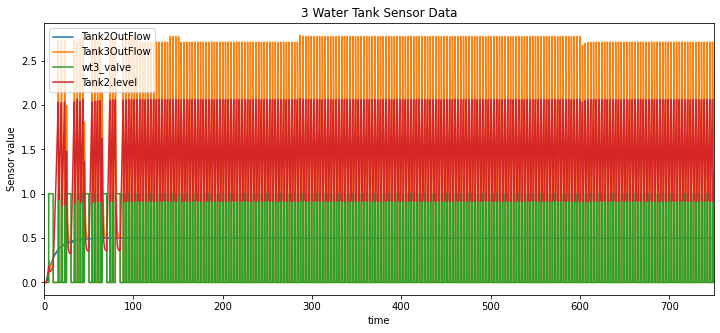

In [42]:
# ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
title = '3 Water Tank Sensor Data'
ylabel = 'Sensor value'
xlabel = ''
ax = df_raw['Tank2OutFlow'].plot(legend=True, title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
df_raw['Tank3OutFlow'].plot(legend=True)
df_raw['wt3_valve'].plot(legend=True)
# df_raw['Tank2.puddle'].plot(legend=True)
df_raw['Tank2.level'].plot(legend=True)
plt.show()

In [43]:
# Augmented Dickey-Fuller Test
def adf_test(series, title=''):
    '''
    Hypothesis Test for Stationarity
    Pass in a time series and an optional title, return an ADF report
    '''
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC')
    labels = ['ADF test statistics','p-value','#lags','#observations'] # use help(adfuller) to understand why these labels are chosen
    
    outcome = pd.Series(result[0:4],index=labels)
    
    for key,val in result[4].items():
        outcome[f'critical value ({key})'] = val
        
    print(outcome.to_string()) # this will not print the line 'dtype:float64'
    
    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis') # Ho is Data is not stationary, check help(adfuller)
        print('Reject the null hypothesis')
        print('Data is Stationary')
    else:
        print('Weak evidence against the Null hypothesis')
        print('Fail to reject the null hypothesis')
        print('Data has a unit root and is non stationary')

In [44]:
adf_test(df_raw['Tank2.puddle'])

Augmented Dickey-Fuller Test: 
ADF test statistics    -1.466653e+01
p-value                 3.317682e-27
#lags                   4.200000e+01
#observations           1.495800e+04
critical value (1%)    -3.430787e+00
critical value (5%)    -2.861733e+00
critical value (10%)   -2.566873e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data is Stationary


Take the first order difference of the entire dataframe and re-run the dickey fuller test

In [45]:
# All the correlated features are stationary.
df_raw.head()

,Tank2OutFlow,Tank2.puddle,Tank3OutFlow,Tank2.level,wt3_valve
time,,,,,
0.00,0.0,0.022568,0.0,0.0,0
0.05,0.0,0.022568,0.0,0.0,0
0.10,0.0,0.022568,0.0,0.0,0
0.15,0.0,0.022568,0.0,0.0,0
0.20,0.0,0.022568,0.0,0.0,0


### Normalisation of the dataset

In [46]:
# Read the mean and std used for normalising the golden model
var_df = pd.read_csv("norm_var_reduced.csv", index_col=0)
old_means, old_stds = var_df["0"], var_df["1"]

def normalise_series(data, means, stds):
    normalised_data = (data - means) / stds
    return pd.DataFrame(normalised_data)


def denormalise_timeseries(data, means, stds):
    denormalised_data = (data * stds) + means
    return pd.DataFrame(denormalised_data)


normalised_data = normalise_series(df_raw, old_means, old_stds)

In [47]:
df = normalised_data

In [48]:
# Train Test Split
nobs = 3000
train = df.iloc[:-nobs]
test = df.iloc[-nobs:]
len(train), len(test)

(12001, 3000)

### VAR Model Order Selection

In [49]:
# from statsmodels.tsa.vector_ar.var_model import VAROrderSelection
# Perform order selection using auto-arima
model = VAR(train)
# Select the best order based on a specific criterion (e.g. AIC, BIC)
selected_order = model.select_order()
# Get the selected order (lag length)
order = selected_order.selected_orders['aic']
min_aic_index = order
print('Order {0} has the least AIC value. Let us select p = {0} in the modelling'.format(min_aic_index))

Order 40 has the least AIC value. Let us select p = 40 in the modelling


In [50]:
# p = [1,2,3,4,5,6,7] # try with list of 7 p values
# p = list(range(1,20))
# aic, bic = [], []
# for i in p:
#     model = VAR(train)
#     results = model.fit(i)
#     aic.append(results.aic)
#     bic.append(results.bic)
#     print(f'VAR Order {i}')
#     print('AIC: {}'.format(results.aic))
#     print('BIC: {}'.format(results.bic))
#     print()

# min_aic = min(aic)
# min_aic_index = aic.index(min_aic) + 1
# min_bic = min(bic)
# min_bic_index = bic.index(min_bic) + 1
# print('Order {0} has the least AIC value. Let us select p = {0} in the modelling'.format(min_aic_index))


In [51]:
# let's confirm that both the variables are included in the model
model.endog_names

['Tank2OutFlow', 'Tank2.puddle', 'Tank3OutFlow', 'Tank2.level', 'wt3_valve']

### Fit the VAR {{min_aic_index}}  model

In [52]:
min_aic_index

40

In [53]:
results = model.fit(min_aic_index)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 02, Aug, 2023
Time:                     15:55:15
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -46.4316
Nobs:                     11961.0    HQIC:                  -46.8441
Log likelihood:           197542.    FPE:                3.67617e-21
AIC:                     -47.0524    Det(Omega_mle):     3.38227e-21
--------------------------------------------------------------------
Results for equation Tank2OutFlow
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.000512         0.000026           19.330           0.000
L1.Tank2OutFlow          1.322101         0.009053          146.035           0.000
L1.Tank2.puddle          0.146917        

### Predict the next 20 values

In [54]:
# For predictions, VAR model uses .forecast() instead of predictions.
lag_order = results.k_ar
lag_order

40

In [55]:
df.head()

,Tank2OutFlow,Tank2.puddle,Tank3OutFlow,Tank2.level,wt3_valve
time,,,,,
0.00,-10.143714,-2.604337,-0.560669,-4.02458,-0.581122
0.05,-10.143714,-2.604337,-0.560669,-4.02458,-0.581122
0.10,-10.143714,-2.604337,-0.560669,-4.02458,-0.581122
0.15,-10.143714,-2.604337,-0.560669,-4.02458,-0.581122
0.20,-10.143714,-2.604337,-0.560669,-4.02458,-0.581122


In [56]:
steps = 20
# z = results.forecast(y=train.values[-lag_order:], steps = 20)
z = results.forecast(y=train.values[-lag_order:], steps=steps)
z

array([[ 0.18120481,  0.95163429,  2.03976473,  0.38043011,  1.71610044],
       [ 0.19520229,  0.95244904,  1.87034593,  0.10561654,  1.71921979],
       [ 0.18004244,  0.95282628,  1.77245924, -0.06358927,  1.72249005],
       [ 0.1532445 ,  0.95354234,  1.63842116, -0.3034811 ,  1.6996933 ],
       [ 0.15951224,  0.95384766,  1.52255432, -0.44910548,  1.71927497],
       [ 0.19082094,  0.95447382,  1.42702251, -0.65693761,  1.71203479],
       [ 0.19463104,  0.9547448 ,  1.34098589, -0.78503834,  1.7163454 ],
       [ 0.16850087,  0.95528773,  1.24025937, -0.96481618,  1.70392115],
       [ 0.1537068 ,  0.95553609,  1.15550969, -1.07506877,  1.71242467],
       [ 0.16892179,  0.95602655,  1.07594481, -1.23095106,  1.71479857],
       [ 0.19057414,  0.95627274,  1.01903668, -1.32773842,  1.69087641],
       [ 0.18936453,  0.95672899,  0.9209445 , -1.46051436, -0.57093999],
       [ 0.16821522,  0.95655697, -0.55454189, -1.41570084, -0.56361078],
       [ 0.15449055,  0.95635698, -0.5

In [57]:
test

,Tank2OutFlow,Tank2.puddle,Tank3OutFlow,Tank2.level,wt3_valve
time,,,,,
600.05,0.181157,0.951784,2.037769,0.379838,1.720809
600.10,0.195506,0.952568,1.875520,0.104822,1.720809
600.15,0.180842,0.953064,1.774735,-0.066011,1.720809
600.20,0.153725,0.953769,1.633707,-0.305057,1.720809
600.25,0.159884,0.954216,1.545985,-0.453748,1.720809
...,...,...,...,...,...
749.80,0.181158,1.384282,-0.560669,-0.846090,-0.581122
749.85,0.196210,1.384282,-0.560669,-0.790357,-0.581122
749.90,0.180843,1.384282,-0.560669,-0.706624,-0.581122


In [58]:
attr = list(pd.read_csv(file_name).columns.values)[1:]
df_forecast = pd.DataFrame(z, columns=attr)
df_forecast[:5]

,Tank2OutFlow,Tank2.puddle,Tank3OutFlow,Tank2.level,wt3_valve
0,0.181205,0.951634,2.039765,0.380430,1.716100
1,0.195202,0.952449,1.870346,0.105617,1.719220
2,0.180042,0.952826,1.772459,-0.063589,1.722490
3,0.153244,0.953542,1.638421,-0.303481,1.699693
4,0.159512,0.953848,1.522554,-0.449105,1.719275


### Plot the results

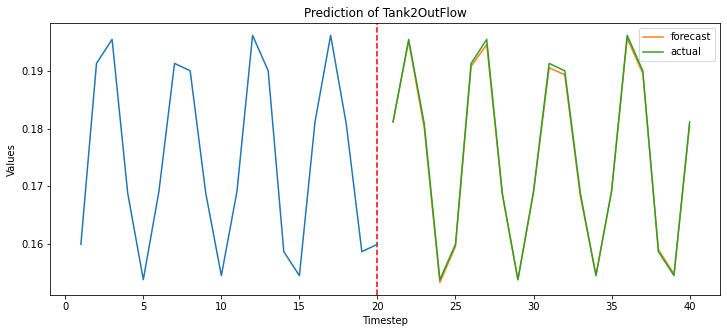

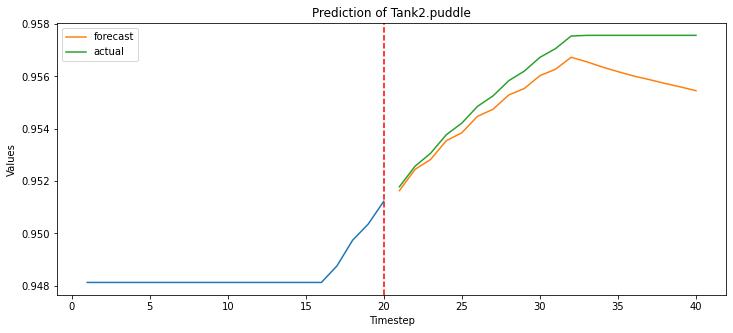

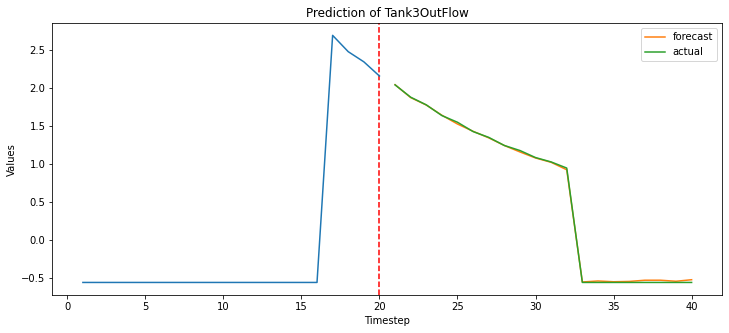

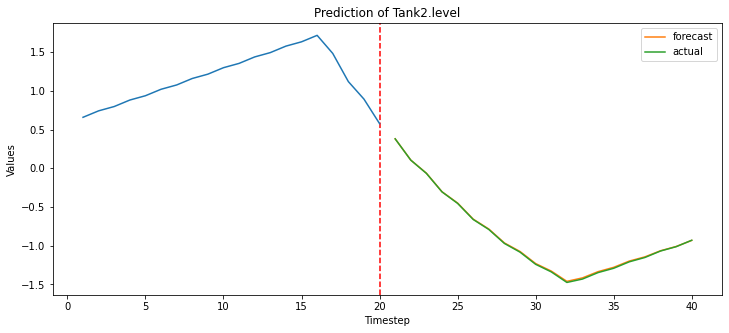

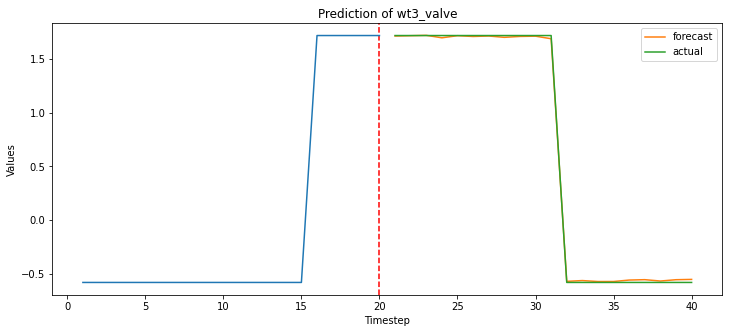

In [59]:
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
# for i in range(len(attr)):
#     title = "Prediction of {}".format(attr[i])
#     actual_index = pd.Index(list(range(lag_order)))
#     actual = train.iloc[-lag_order:,:]
    
#     index = pd.Index(list(range(lag_order, lag_order + steps)))
#     actual = actual.set_index(actual_index)
#     pred = df_forecast.set_index(index)
#     actual_test = test.iloc[:lag_order+1,:].set_index(index)
#     # draw a vertical line at x=19
#     plt.axvline(x=lag_order, ls='--', color='red')
# #     pred = df_forecast
#     plt.title(title)
#     plt.xlabel("Timestep")
#     plt.ylabel("Values")
#     plt.plot(actual.iloc[:,i])
#     plt.plot(pred.iloc[:,i], label="forecast")
#     plt.plot(actual_test.iloc[:,i], label="actual")
#     plt.legend()
#     plt.show()
    
    
    
attr = list(pd.read_csv('stuckat1_training_reduced.csv').columns.values)[1:]
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
input_length = 20
for i in range(len(attr)):
    title = "Prediction of {}".format(attr[i])
    actual_index = pd.Index(list(range(1,input_length+1)))
#     actual = train.iloc[-lag_order:,:] # CORRECT BEFORE EDITING
    actual = train.iloc[-input_length:,:]
    
#     index = pd.Index(list(range(lag_order, lag_order + steps))) # CORRECT BEFORE EDITING
    index = pd.Index(list(range(input_length+1, input_length + steps +1)))
    actual = actual.set_index(actual_index)
    pred = df_forecast.set_index(index)
    actual_test = test.iloc[:input_length,:].set_index(index)
    # draw a vertical line at x=20
#     plt.axvline(x=lag_order, ls='--', color='red') # CORRECT BEFORE EDITING
    plt.axvline(x=input_length, ls='--', color='red')
#     pred = df_forecast
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel("Values")
    plt.plot(actual.iloc[:,i])
    plt.plot(pred.iloc[:,i], label="forecast")
    plt.plot(actual_test.iloc[:,i], label="actual")
    plt.legend()
    plt.show()

### Model Evaluation

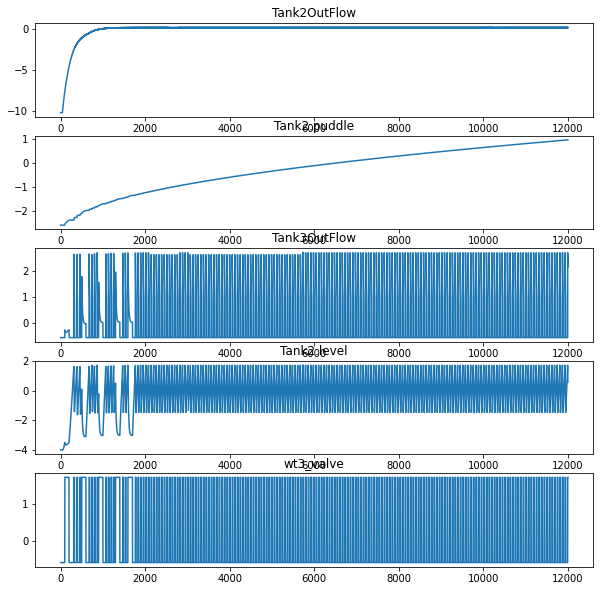

In [60]:
results.plot();

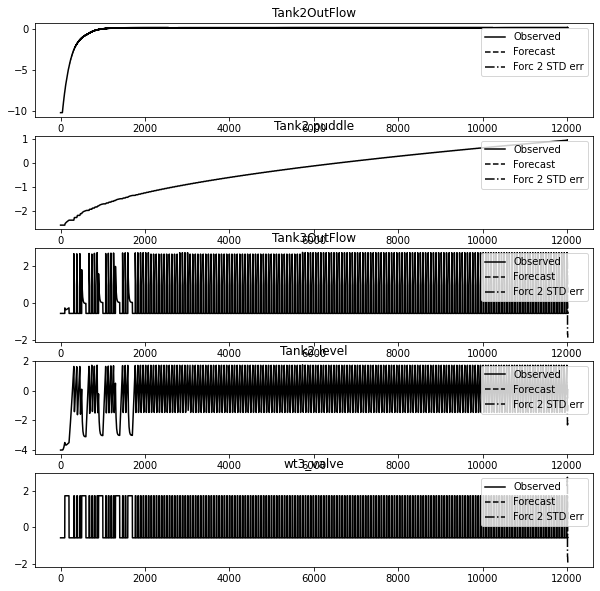

In [61]:
results.plot_forecast(20);

In [62]:
len(df_forecast)

20

In [63]:
len(df['Tank2.level'].iloc[:steps])

20

### Model Evaluation

In [64]:
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
RMSE = []
for feat in attr:
    RMSE.append(rmse(pred[feat], actual_test[feat]))

print(RMSE)

[0.0004834652707880448, 0.001108347785918712, 0.016572781196505147, 0.008118482928560183, 0.016150859279910525]


### Save the model

In [65]:
# Serialize andsave the model
import pickle
import statsmodels.api as sm
with open('var_ctrl_stuckat1_perm_reduced.pkl', 'wb') as f:
    pickle.dump(results, f)
print("Model saved!")

Model saved!


In [66]:
print("Stop execution here")
print(error)

Stop execution here


NameError: name 'error' is not defined

### Define the faulty data

In [ ]:
faulty_data = pd.read_csv('test_fault.csv', index_col=0, header=0, parse_dates=True)
faulty_data.index.freq = 'MS'
num_obs = 3000

# train_faulty = faulty_data.iloc[-num_obs:]
# test_faulty = faulty_data.iloc[:-num_obs]

train_faulty = faulty_data.iloc[:-num_obs]
test_faulty = faulty_data.iloc[-num_obs:]
len(train_faulty), len(test_faulty)

### Load the model and reconstruct VAR

In [ ]:
with open('var_ctrl_stuckat1.pkl', 'rb') as f:
    params = pickle.load(f)
    
stuckat1_model = sm.tsa.VAR(train)
stuckat1_model.params = params
stuckat1_model_fit = stuckat1_model.fit(min_aic_index)

stuckat1_model_fit.summary()

### Forecast using faulty data

In [ ]:
# Use the loaded model to make predictions or perform other analyses
forecast = stuckat1_model_fit.forecast(y=train_faulty.values[-lag_order:], steps=20)
# forecast = golden_model_fit.forecast(params, start=len(train), end=len(train)+10)
forecast

In [ ]:
fault_forecast = pd.DataFrame(forecast, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])

attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
for i in range(len(attr)):
    title = "Prediction of {}".format(attr[i])
    actual_index_f = pd.Index(list(range(lag_order)))
    actual_f = train_faulty.iloc[-lag_order:,:]
    
    index_f = pd.Index(list(range(lag_order, lag_order + steps)))
    actual_f = actual_f.set_index(actual_index_f)
    pred_f = fault_forecast.set_index(index_f)
    actual_test_f = test_faulty.iloc[:lag_order+1,:].set_index(index_f)
    # draw a vertical line at x=19
    plt.axvline(x=lag_order, ls='--', color='red')
#     pred = df_forecast
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel("Values")
    plt.plot(actual_f.iloc[:,i])
    plt.plot(pred_f.iloc[:,i], label="forecast")
    plt.plot(actual_test_f.iloc[:,i], label="actual")
    plt.legend()
    plt.show()

In [ ]:
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
RMSEf = []
for feat in attr:
    RMSEf.append(rmse(df[feat].iloc[:steps], fault_forecast[feat]))

print(RMSEf)

### Increasing the duration of faults

In [ ]:
faulty_data_extend = pd.read_csv('test_extend.csv', index_col=0, header=0, parse_dates=True)

faulty_data_extend.index.freq = 'MS'
num_obs = 3000

# train_faulty = faulty_data.iloc[-num_obs:]
# test_faulty = faulty_data.iloc[:-num_obs]

train_faulty_extend = faulty_data_extend.iloc[:-num_obs]
test_faulty_extend = faulty_data_extend.iloc[-num_obs:]
len(train_faulty_extend), len(test_faulty_extend)

In [ ]:
# Use the loaded model to make predictions or perform other analyses
forecast_extend = stuckat1_model_fit.forecast(y=train_faulty_extend.values[-lag_order:], steps=20)

In [ ]:
fault_forecast = pd.DataFrame(forecast_extend, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])

attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
for i in range(len(attr)):
    title = "Prediction of {}".format(attr[i])
    actual_index_f = pd.Index(list(range(lag_order)))
    actual_f = train_faulty.iloc[-lag_order:,:]
    
    index_f = pd.Index(list(range(lag_order, lag_order + steps)))
    actual_f = actual_f.set_index(actual_index_f)
    pred_f = fault_forecast.set_index(index_f)
    actual_test_f = test_faulty.iloc[:lag_order+1,:].set_index(index_f)
    # draw a vertical line at x=19
    plt.axvline(x=lag_order, ls='--', color='red')
#     pred = df_forecast
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel("Values")
    plt.plot(actual_f.iloc[:,i])
    plt.plot(pred_f.iloc[:,i], label="forecast")
    plt.plot(actual_test_f.iloc[:,i], label="actual")
    plt.legend()
    plt.show()

In [ ]:
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
RMSEf = []
for feat in attr:
    RMSEf.append(rmse(df[feat].iloc[:steps], fault_forecast[feat]))

print(RMSEf)